# Reconhecimento de Padrões (TIP8311) - Trabalho 3


**Professor:** Guilherme de Alencar Barreto  

<img src="https://loop.frontiersin.org/images/profile/243428/203" alt="Foto do Professor" width="150"/>


**Aluno:** Luis Felipe Carneiro de Souza    **Matrícula:** 535049

In [94]:
import pandas as pd
import numpy as np
import time
from scipy.spatial.distance import minkowski
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs


In [2]:
data_path = "wall+following+robot+navigation+data/sensor_readings_24.data"

## Questão 01

Para este trabalho computacional, considere o conjunto de dados disponível no site abaixo.

Usando o conjunto original para 24 sensores de ultrassom. Pede-se:

1.1. Identificar para o problema em questão o número de classes, o númeor de instâncias/exemplos de cada classe e a dimensão do vetor de atributos.

1.2. Verificar se as matrizes de covariância das classes são invertíveis ou não.

1.3. Implementar e avaliar os seguintes classificadors: (1) classificador quadrático gaussiano (CQG) e (2) classificador de distância mímina ao protótipo¹ (DMP). Preencher a tabela abaixo após Nr = 100 Rodadas de treinamento/teste. Comente os resultados obtidos.



| Classificador | Média ± Desvio Padrão (Global) | Média ± Desvio Padrão (Classe 1) | Média ± Desvio Padrão (Classe 2) | Média ± Desvio Padrão (Classe 3) | Média ± Desvio Padrão (Classe 4) |
|---------------|--------------------------------|----------------------------------|----------------------------------|----------------------------------|----------------------------------|
| CQG           |                                |                                  |                                  |                                  |                                  |
| DMP           |                                |                                  |                                  |                                  |                                  |


In [ ]:
df = pd.read_csv(filepath_or_buffer=data_path, header=None)

In [3]:
data = np.genfromtxt(fname=data_path, delimiter=",", dtype=str, encoding="utf-8")

X = data[:, :-1].astype(float)  # todas menos a última coluna convertidas para float
y = data[:, -1]                 # última coluna como string

y = y.reshape(-1, 1)

# X, y
X.shape

(5456, 24)

In [4]:
class CQG:
    def __init__(self, reg=1e-8):
        self.C = None         # classes
        self.mcov = None      # dict: classe -> matriz de covariância (p x p)
        self.means = None     # dict: classe -> vetor média (p x 1)
        self.priors = None    # dict: classe -> prior f(ωi)
        self.reg = reg        # regularização para estabilidade numérica

    def _mcov(self, X_i):
        # X_i: shape (p, N) -> p = nº features, N = nº amostras
        p, N = X_i.shape
        m = X_i.mean(axis=1).reshape(-1,1)
        R = (X_i @ X_i.T) / N
        C = R - (m @ m.T)
        return C

    def fit(self, X, y):
        """
        Treina o modelo.
        X: (n_samples, n_features)
        y: (n_samples, 1) ou (n_samples,)
        """
        y_flat = y.ravel()
        self.C = np.sort(np.unique(y_flat))
        self.mcov = {}
        self.means = {}
        self.priors = {}

        n = X.shape[0]
        for c in self.C:
            idx = np.where(y_flat == c)[0]
            Xc = X[idx]                 # shape (Nc, p)
            Nc = Xc.shape[0]
            if Nc == 0:
                raise ValueError(f"Classe {c} sem amostras.")

            # média como vetor coluna (p,1)
            mean_c = Xc.mean(axis=0).reshape(-1,1)

            # covariância usando _mcov (espera p x N)
            cov_c = self._mcov(Xc.T)

            # regularização na diagonal para evitar singularidade
            cov_c = cov_c + self.reg * np.eye(cov_c.shape[0])

            prior_c = Nc / n

            self.means[c] = mean_c
            self.mcov[c] = cov_c
            self.priors[c] = prior_c

    def _Qi(self, x_col, mean_col, inv_cov):
        """
        Calcula Q_i(x) = (x - m_i)^T C_i^{-1} (x - m_i)
        x_col, mean_col: (p,1)
        inv_cov: (p,p)
        retorna escalar
        """
        diff = x_col - mean_col
        return diff.T @ inv_cov @ diff

    def predict(self, X):
        """
        Prediz rótulos para X (n_samples, n_features).
        Retorna array com rótulos (mesmo tipo de self.C).
        """
        if self.C is None:
            raise ValueError("Modelo não treinado. Chame fit(X, y) primeiro.")

        n, p = X.shape
        preds = np.empty(n, dtype=self.C.dtype)

        # pré-computar inversas e log-determinantes por classe
        invs = {}
        logdets = {}
        for c in self.C:
            cov = self.mcov[c]
            # usar slogdet para estabilidade
            sign, logdet = np.linalg.slogdet(cov)
            if sign <= 0:
                # fallback (deveria ser raro por causa da regularização)
                logdet = np.log(np.linalg.det(cov) + 1e-20)
            invs[c] = np.linalg.inv(cov)
            logdets[c] = logdet

        for i in range(n):
            x_col = X[i].reshape(-1,1)
            best_c = None
            best_g = np.inf  # queremos o menor g_i^*(x)
            for c in self.C:
                inv_cov = invs[c]
                Qi = self._Qi(x_col, self.means[c], inv_cov)
                # g*_i(x) = Qi(x) + ln(|Ci|) - 2 ln(f(ωi))
                prior = self.priors[c]
                # evitar log(0)
                if prior <= 0:
                    raise ValueError(f"Prior da classe {c} é zero.")
                g = Qi + logdets[c] - 2.0 * np.log(prior)
                if g < best_g:
                    best_g = g
                    best_c = c
            preds[i] = best_c

        return preds


In [78]:
class CQG:
    def __init__(self, reg=1e-8):
        self.reg = float(reg)
        self.classes_ = None
        self.means_ = {}
        self.priors_ = {}
        self.inv_covs_ = {}
        self.logdets_ = {}

    def _mcov(self, X_i):
        """
        Calcula a matriz de covariância manualmente.
        X_i: shape (p, N) -> p = nº features, N = nº amostras
        """
        p, N = X_i.shape
        m = X_i.mean(axis=1).reshape(-1, 1)
        R = (X_i @ X_i.T) / N
        C = R - (m @ m.T)
        return C

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y).ravel()
        
        self.classes_ = np.sort(np.unique(y))
        n_samples = X.shape[0]

        for c in self.classes_:
            Xc = X[y == c]
            Nc = len(Xc)

            # 1. Priori e Médias (média armazenada como 1D para o predict vetorizado)
            self.priors_[c] = Nc / n_samples
            self.means_[c] = Xc.mean(axis=0)

            # 2. Covariância usando o seu método manual (passando Xc transposto)
            cov_c = self._mcov(Xc.T)
            
            # 3. Regularização para estabilidade numérica
            cov_c += self.reg * np.eye(cov_c.shape[0])

            # 4. Pré-computar inversa e log-determinante no momento do TREINO
            sign, logdet = np.linalg.slogdet(cov_c)
            self.logdets_[c] = logdet
            self.inv_covs_[c] = np.linalg.inv(cov_c)

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        n_samples = X.shape[0]
        
        # Matriz para armazenar o score g_i(x) de cada amostra para cada classe
        scores = np.zeros((n_samples, len(self.classes_)))

        for idx, c in enumerate(self.classes_):
            # Diferença vetorizada: amostras - média da classe C
            diff = X - self.means_[c] 
            
            # Cálculo vetorizado de Q_i(x) = (x - m)^T C^{-1} (x - m)
            Qi = np.sum((diff @ self.inv_covs_[c]) * diff, axis=1)
            
            # Função discriminante: g*_i(x) = Q_i(x) + ln(|C_i|) - 2 ln(P(w_i))
            scores[:, idx] = Qi + self.logdets_[c] - 2.0 * np.log(self.priors_[c])

        # A classe predita é a que possui o MENOR score g_i(x)
        best_class_idx = np.argmin(scores, axis=1)
        return self.classes_[best_class_idx]

In [86]:
class Kmeans:
    """K-means sequencial (online) com alpha = 1 / count_i(t) e kmeans++."""

    def __init__(self, k=3, max_epochs=100, tol=1e-4, random_state=None,
                 init='random', handle_empty='reinit'):
        self.k = int(k)
        self.max_epochs = int(max_epochs)
        self.tol = float(tol)
        self.random_state = random_state
        self.init = init
        self.handle_empty = handle_empty

        self.centroids = None
        self.counts = None
        self.inertia_ = None
        self.n_iter_ = 0
        self.rng = np.random.default_rng(random_state)

    def _check_X(self, X):
        if not isinstance(X, np.ndarray):
            X = np.asarray(X, dtype=float)
        else:
            X = X.astype(float, copy=False)
        if X.ndim != 2:
            raise ValueError("X deve ser 2D com shape (n_samples, n_features).")
        if np.isnan(X).any():
            raise ValueError("X contém NaNs. Trate-os antes de ajustar.")
        return X

    def _init_centroids(self, X):
        n, _ = X.shape
        if self.k > n:
            raise ValueError("k não pode ser maior que o número de amostras.")

        if self.init == 'random':
            idx = self.rng.choice(n, size=self.k, replace=False)
            self.centroids = X[idx].astype(float).copy()
        elif self.init == 'kmeans++':
            # kmeans++ initialization
            centroids = np.empty((self.k, X.shape[1]), dtype=float)
            # 1) choose first centroid uniformly at random
            first_idx = int(self.rng.integers(0, n))
            centroids[0] = X[first_idx]
            # 2) choose remaining centroids
            # distances squared to nearest chosen centroid
            closest_dist_sq = np.sum((X - centroids[0])**2, axis=1)
            for c in range(1, self.k):
                # probability proportional to distance squared
                total = closest_dist_sq.sum()
                if total == 0.0:
                    # all points identical to chosen centroids; pick random remaining
                    next_idx = int(self.rng.integers(0, n))
                else:
                    probs = closest_dist_sq / total
                    next_idx = int(self.rng.choice(n, p=probs))
                centroids[c] = X[next_idx]
                # update closest distances squared
                dist_to_new = np.sum((X - centroids[c])**2, axis=1)
                closest_dist_sq = np.minimum(closest_dist_sq, dist_to_new)
            self.centroids = centroids
        else:
            # fallback para random
            idx = self.rng.choice(n, size=self.k, replace=False)
            self.centroids = X[idx].astype(float).copy()

        self.counts = np.zeros(self.k, dtype=int)

    def _handle_empty_clusters(self, X, labels):
        for i in range(self.k):
            if np.sum(labels == i) == 0:
                if self.handle_empty == 'reinit':
                    self.centroids[i] = X[self.rng.integers(0, X.shape[0])]
                    self.counts[i] = 0
                elif self.handle_empty == 'farthest':
                    dists = np.linalg.norm(X[:, None] - self.centroids[None, :], axis=2)
                    far_idx = np.argmax(np.min(dists, axis=1))
                    self.centroids[i] = X[far_idx]
                    self.counts[i] = 0

    def predict(self, X):
        if self.centroids is None:
            raise RuntimeError("Modelo não treinado. Chame fit(X) primeiro.")
        X = self._check_X(X)
        dists = np.linalg.norm(X[:, None, :] - self.centroids[None, :, :], axis=2)
        return np.argmin(dists, axis=1)

    def fit(self, X):
        X = self._check_X(X)
        n, _ = X.shape
        self._init_centroids(X)
        prev_centroids = self.centroids.copy()

        for epoch in range(1, self.max_epochs + 1):
            perm = self.rng.permutation(n)
            X_shuffled = X[perm]

            for x in X_shuffled:
                dists = np.linalg.norm(self.centroids - x, axis=1)
                i_star = int(np.argmin(dists))
                self.counts[i_star] += 1
                alpha = 1.0 / self.counts[i_star]
                self.centroids[i_star] = (1 - alpha) * self.centroids[i_star] + alpha * x

            labels = self.predict(X)
            self._handle_empty_clusters(X, labels)

            shift = np.linalg.norm(self.centroids - prev_centroids)
            prev_centroids = self.centroids.copy()
            self.n_iter_ = epoch

            dists = np.linalg.norm(X - self.centroids[labels], axis=1)
            self.inertia_ = float(np.sum(dists ** 2))

            if shift < self.tol:
                break

        return self


In [ ]:
class Kmeans:
    def __init__(self, k=3, max_epochs=100, tol=1e-4):
        self.k = k
        self.max_epochs = max_epochs
        self.tol = float(tol)
        
        self.centroids = None
        self.counts = None
        self.n_iter_ = 0
        self.labels_ = None
        self.inertia_ = None
        self.cluster_centers_ = None
    

    def fit(self, X):
        n = len(X)

        self._init_centroids(X)

        SSD = []
        prev_controids = None

        for r in range(self.max_epochs):

            dmin, icluster = [], []

            for t in range(n):
                dist = []
                for k_ in range(self.k):
                    diff = X[t, :] - self.centroids[k_, :]
                    dist.append(sum((diff)**2))

                dmin.append(np.min(dist))
                # dmin = np.array(dmin)
                icluster.append(np.argmin(dist))
                # icluster = np.array(icluster)

            SSD.append(np.sum(dmin))

            particao = []
            for k_ in range(self.k):
                mask_i = (icluster == k_)
                particao.append(X[mask_i, :])
                self.centroids[k_, :] = np.mean(particao[k_], axis=0)

            for t in range(n):
                dist = []
                for k_ in range(self.k):
                    diff = X[t, :] - self.centroids[k_, :]
                    dist.append(sum(abs(diff)**2))
                dist = np.array(dist)
                dummy = np.min(dist)
                icluster[t] = np.argmin(dist)

            if prev_controids is not None:
                shift = np.linalg.norm(self.centroids - prev_controids, axis=1)
                if np.max(shift) < self.tol:
                    self.n_iter = r + 1
                    self.labels_ = icluster
                    self.inertia_ = SSD[-1]
                    self.cluster_centers_ = self.centroids.copy()
                    return self
                
            prev_controids = self.centroids.copy()

        self.n_iter_ = self.n_iter_ or self.max_epochs
        self.labels_ = icluster
        self.inertia_ = SSD[-1] if SSD else 0.0
        self.cluster_centers_ = self.centroids.copy()
        return self  

    def _init_centroids(self, X):
        n = len(X)
        idx = np.random.choice(n, size=self.k, replace=False)
        self.centroids = X[idx].astype(float)

In [ ]:
class Kmeans:
    def __init__(self, k=3, max_epochs=100, tol=1e-4):
        self.k = int(k)
        self.max_epochs = int(max_epochs)
        self.tol = float(tol)

        self.centroids = None
        self.centroids_labels = None
        self.counts = None
        self.n_iter_ = 0
        self.labels_ = None
        self.inertia_ = None
        self.cluster_centers_ = None

    def fit(self, X):
        X = np.asarray(X)
        n, m = X.shape

        self._init_centroids(X)

        SSD = []
        prev_centroids = None

        for r in range(self.max_epochs):
            # Atribuição: calcular distâncias e rótulos
            dmin = np.empty(n, dtype=float)
            icluster = np.empty(n, dtype=int)

            for t in range(n):
                dist = np.empty(self.k, dtype=float)
                for k_ in range(self.k):
                    diff = X[t, :] - self.centroids[k_, :]
                    dist[k_] = np.sum(diff**2)   # distância ao quadrado
                dmin[t] = np.min(dist)
                icluster[t] = np.argmin(dist)

            SSD.append(np.sum(dmin))  # dmin já é distância ao quadrado

            # Atualização dos centróides
            for k_ in range(self.k):
                mask_i = (icluster == k_)
                if np.any(mask_i):
                    self.centroids[k_, :] = np.mean(X[mask_i, :], axis=0)
                else:
                    # Partição vazia: manter centróide anterior (mínima alteração)
                    # alternativa: re-inicializar com ponto aleatório
                    pass

            # Critério de parada por convergência dos centróides
            if prev_centroids is not None:
                shift = np.linalg.norm(self.centroids - prev_centroids, axis=1)
                if np.max(shift) < self.tol:
                    self.n_iter_ = r + 1
                    self.labels_ = icluster
                    self.inertia_ = SSD[-1]
                    self.cluster_centers_ = self.centroids.copy()
                    return self

            prev_centroids = self.centroids.copy()

        # Finalização após max_epochs
        self.n_iter_ = self.n_iter_ or self.max_epochs
        self.labels_ = icluster
        self.inertia_ = SSD[-1] if SSD else 0.0
        self.cluster_centers_ = self.centroids.copy()
        return self

    def predict(self, X):
        n = len(X)
        k = len(self.centroids)

        label_pred = []
        
        for i in range(n):
            dist = []
            for j in range(k):
                diff = X[i, :] - self.centroids[j, :]
                dist.append(np.sum(diff ** 2))

            idx = np.argmin(dist)
            label_pred.append(self.centroids_labels[idx])

        return np.array(label_pred).reshape(-1, 1)

    def _init_centroids(self, X):
        n = X.shape[0]
        if self.k > n:
            raise ValueError("k must be <= number of samples")
        idx = np.random.choice(n, size=self.k, replace=False)
        self.centroids = X[idx].astype(float)


In [60]:
class Kmeans:
    def __init__(self, k=3, max_epochs=100, tol=1e-4):
        self.k = int(k)
        self.max_epochs = int(max_epochs)
        self.tol = float(tol)
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None

    def fit(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]

        # Inicialização simples (aleatória)
        idx = np.random.choice(n_samples, size=self.k, replace=False)
        self.centroids = X[idx].copy()

        for _ in range(self.max_epochs):
            # 1. Cálculo de distâncias (Vetorizado: N amostras x K centróides)
            # Cria uma matriz de distâncias onde dists[i, j] é a dist da amostra i ao centróide j
            dists = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2) ** 2
            
            # 2. Atribuição de clusters (menor distância)
            new_labels = np.argmin(dists, axis=1)
            
            # Cálculo da inércia (soma das distâncias mínimas ao quadrado)
            self.inertia_ = np.sum(np.min(dists, axis=1))

            # 3. Atualização dos centróides
            new_centroids = np.zeros_like(self.centroids)
            for k in range(self.k):
                mask = (new_labels == k)
                if np.any(mask):
                    new_centroids[k] = np.mean(X[mask], axis=0)
                else:
                    # Se cluster vazio, mantém o antigo para estabilidade
                    new_centroids[k] = self.centroids[k]

            # 4. Critério de parada
            shift = np.linalg.norm(new_centroids - self.centroids)
            self.centroids = new_centroids
            self.labels_ = new_labels

            if shift < self.tol:
                break
        
        return self

    def predict(self, X):
        # Calcula distâncias para os centróides aprendidos e retorna o índice do mais próximo
        dists = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2) ** 2
        return np.argmin(dists, axis=1)

# Exemplo de uso
# model = Kmeans(k=3)
# model.fit(X)
# clusters = model.predict(X)

In [64]:
def davies_bouldin_score(X, labels, centroids, q=2, t=2):
    k = len(centroids)
    # O índice DB avalia a separação entre clusters, logo, não faz sentido para K=1.
    if k < 2:
        return float('inf') 

    # Equação 27: Calcular a dispersão intra-grupo S_i
    S = np.zeros(k)
    for i in range(k):
        mask = (labels == i)
        N_i = np.sum(mask)
        if N_i > 0:
            diffs = np.abs(X[mask] - centroids[i])
            # Soma de ||x - w_i||^q
            dist_q = np.sum(diffs ** q, axis=1) 
            S[i] = (np.sum(dist_q) / N_i) ** (1 / q)
        else:
            S[i] = 0.0 # Cluster vazio

    # Equações 25 e 26: Calcular o índice DB
    db_index = 0.0
    for i in range(k):
        max_R = -np.inf
        for j in range(k):
            if i != j:
                # Equação 28: Distância de Minkowski de ordem t entre centróides
                d_ij = np.sum(np.abs(centroids[i] - centroids[j]) ** t) ** (1 / t)
                
                # Equação 26: Razão R_{i,qt}
                if d_ij == 0:
                    R_ij = 0.0 # Evita divisão por zero se centróides colidirem
                else:
                    R_ij = (S[i] + S[j]) / d_ij
                    
                if R_ij > max_R:
                    max_R = R_ij
                    
        db_index += max_R
        
    return db_index / k

In [73]:
class DMP:
    def __init__(self, k_min=2, k_max=5, n_runs=5, max_epochs=100, q=2, t=2):
        self.k_min = int(k_min)
        self.k_max = int(k_max)
        self.n_runs = int(n_runs)
        self.max_epochs = int(max_epochs)
        self.q = int(q)
        self.t = int(t)
        
        self.prototypes_ = None
        self.labels_ = None
        self.k_opt_ = {} # Dicionário para guardarmos o K ótimo de cada classe

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).ravel()
        
        # Passo 1: Separar as instâncias
        classes = np.unique(y)
        
        all_prototypes = []
        all_labels = []
        
        # Passo 7: Repetir para cada classe
        for c in classes:
            X_c = X[y == c]
            n_samples = len(X_c)
            
            # Garante que não vamos procurar um K maior que a quantidade de dados da classe
            k_max_c = min(self.k_max, n_samples)
            k_min_c = min(self.k_min, n_samples)
            
            # Se a classe tiver apenas 1 amostra, K_opt é forçosamente 1
            if k_max_c < 2:
                self.k_opt_[c] = 1
                all_prototypes.append(X_c)
                all_labels.extend([c])
                continue

            best_k_overall = k_min_c
            min_db_score = float('inf')
            best_centroids_overall = None
            
            # Passo 5: Varrer de K_min até K_max para achar o K_opt
            for k in range(k_min_c, k_max_c + 1):
                best_inertia = float('inf')
                best_centroids = None
                best_labels = None
                
                # Passo 2: Aplicar K-médias por Nr rodadas
                for _ in range(self.n_runs):
                    kmeans = Kmeans(k=k, max_epochs=self.max_epochs)
                    kmeans.fit(X_c)
                    
                    # Passo 3: Escolher a rodada com menor SSD (Inércia)
                    if kmeans.inertia_ < best_inertia:
                        best_inertia = kmeans.inertia_
                        best_centroids = kmeans.centroids.copy()
                        best_labels = kmeans.labels_.copy()
                        
                # Passo 4: Calcular o índice de validação DB para o melhor K-médias deste 'k'
                db_score = davies_bouldin_score(X_c, best_labels, best_centroids, q=self.q, t=self.t)
                
                # Passo 5: Atualizar se encontrarmos um DB menor (partição mais válida)
                if db_score < min_db_score:
                    min_db_score = db_score
                    best_k_overall = k
                    best_centroids_overall = best_centroids.copy()
            
            # Passo 6: Armazenar os protótipos ótimos da classe
            self.k_opt_[c] = best_k_overall
            all_prototypes.append(best_centroids_overall)
            all_labels.extend([c] * best_k_overall)
            
        # Passo 1 (Classificação): Concatenar a matriz W e os rótulos
        self.prototypes_ = np.vstack(all_prototypes)
        self.labels_ = np.array(all_labels)
        
        return self

    def predict(self, X):
        X = np.asarray(X)
        dists = np.linalg.norm(X[:, np.newaxis] - self.prototypes_, axis=2) ** 2
        nearest_idx = np.argmin(dists, axis=1)
        return self.labels_[nearest_idx].reshape(-1, 1)

In [76]:
class PCA:
    def __init__(self, n_components=None, whiten=False):
        self.n_components = n_components
        self.whiten = bool(whiten)

        self.components_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
        self.mean_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=float)
        n, p = X.shape
        
        # 1. Centralizando os dados
        self.mean_ = X.mean(axis=0)
        Xc = X - self.mean_

        # 2. Decomposição SVD (Singular Value Decomposition)
        # Xc = U * S * Vt
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        
        # 3. Cálculo dos autovalores (variância) e autovetores (componentes)
        vals = (S ** 2) / (n - 1)
        vecs = Vt.T

        # 4. Seleção da quantidade de componentes (q)
        q = self.n_components if self.n_components is not None else min(n, p)

        self.components_ = vecs[:, :q].T  # Shape final: (q, p)
        self.explained_variance_ = vals[:q]
        
        total_var = vals.sum()
        self.explained_variance_ratio_ = (vals[:q] / total_var) if total_var > 0 else np.zeros(q)

        # 5. Aplicação do branqueamento (opcional)
        if self.whiten:
            eps = 1e-12 # Constante de estabilidade para evitar divisão por zero
            self.components_ = self.components_ / np.sqrt(self.explained_variance_[:, None] + eps)

        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        Xc = X - self.mean_
        return np.dot(Xc, self.components_.T)

    def inverse_transform(self, Z):
        Z = np.asarray(Z, dtype=float)
        Xc_rec = np.dot(Z, self.components_)
        return Xc_rec + self.mean_

In [ ]:
def make_bubbles(n_samples=500, centers=4, cluster_std=None, random_state=0):
    """
    Gera um dataset tipo 'bubbles' usando make_blobs.
    - n_samples: total de pontos
    - centers: número de centros (int ou array de coordenadas)
    - cluster_std: escalar ou lista com std por centro (ex: [0.3, 0.6, 1.0, 0.4])
    - random_state: semente para reprodutibilidade
    Retorna: X (n_samples, 2), y (rótulos)
    """
    X, y = make_blobs(n_samples=n_samples,
                      centers=centers,
                      cluster_std=cluster_std,
                      random_state=random_state)
    return X, y

if __name__ == "__main__":
    # Exemplo: 4 bolhas com tamanhos diferentes
    np.random.seed(0)
    centers = 4
    stds = [0.25, 0.6, 1.0, 0.35]   # bolhas de tamanhos variados
    X, y = make_bubbles(n_samples=200, centers=centers, cluster_std=stds, random_state=42)

    # Plot básico
    plt.figure(figsize=(6,6))
    plt.scatter(X[:,0], X[:,1], c=y, cmap='tab10', s=30, edgecolor='k', alpha=0.8)
    plt.title("Dataset sintético tipo 'bubbles' (make_blobs)")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True)
    plt.show()


## Questão 01

Para este trabalho computacional, considere o conjunto de dados disponível no site abaixo.

Usando o conjunto original para 24 sensores de ultrassom. Pede-se:

1.1. Identificar para o problema em questão o número de classes, o númeor de instâncias/exemplos de cada classe e a dimensão do vetor de atributos.

1.2. Verificar se as matrizes de covariância das classes são invertíveis ou não.

1.3. Implementar e avaliar os seguintes classificadors: (1) classificador quadrático gaussiano (CQG) e (2) classificador de distância mímina ao protótipo¹ (DMP). Preencher a tabela abaixo após Nr = 100 Rodadas de treinamento/teste. Comente os resultados obtidos.



In [87]:
data = np.genfromtxt(fname=data_path, delimiter=",", dtype=str, encoding="utf-8")

X = data[:, :-1].astype(float)  # todas menos a última coluna convertidas para float
y = data[:, -1]                 # última coluna como string

# y = y.reshape(-1, 1)

In [88]:
classes, counts = np.unique(y, return_counts=True)
n_amostras, p = X.shape

print(f"Dimensão do vetor de atributos (p): {p}")
print(f"Número de classes: {len(classes)}")
for c, count in zip(classes, counts):
    print(f" -> Classe {c}: {count} instâncias")
print("-" * 40 + "\n")

Dimensão do vetor de atributos (p): 24
Número de classes: 4
 -> Classe Move-Forward: 2205 instâncias
 -> Classe Sharp-Right-Turn: 2097 instâncias
 -> Classe Slight-Left-Turn: 328 instâncias
 -> Classe Slight-Right-Turn: 826 instâncias
----------------------------------------



In [89]:
for c in classes:
    Xc = X[y == c]
    cov = np.cov(Xc, rowvar=False)
    det = np.linalg.det(cov)
    posto = np.linalg.matrix_rank(cov)
    
    # Uma matriz é invertível se seu determinante é != 0 (ou posto == p)
    if np.isclose(det, 0.0):
        status = "NÃO INVERTÍVEL (Singular)"
    else:
        status = "INVERTÍVEL"
        
    print(f"Classe {c}: {status} | Determinante = {det:.2e} | Posto = {posto}/{X.shape[1]}")
print("-" * 40 + "\n")

Classe Move-Forward: INVERTÍVEL | Determinante = 2.56e-01 | Posto = 24/24
Classe Sharp-Right-Turn: INVERTÍVEL | Determinante = 1.23e+01 | Posto = 24/24
Classe Slight-Left-Turn: NÃO INVERTÍVEL (Singular) | Determinante = 3.61e-11 | Posto = 24/24
Classe Slight-Right-Turn: INVERTÍVEL | Determinante = 4.64e-07 | Posto = 24/24
----------------------------------------



In [90]:
def calcular_acuracias(y_true, y_pred, classes):
    """Calcula a acurácia global e por classe"""
    accs = {}
    accs['Global'] = np.mean(y_true == y_pred)
    for c in classes:
        mask = (y_true == c)
        if np.sum(mask) > 0:
            accs[c] = np.mean(y_true[mask] == y_pred[mask])
        else:
            accs[c] = 0.0
    return accs

In [97]:
def executar_experimento(X, y, classes, nr_rodadas=100, q_pca=None):
    """Roda as 100 iterações de treino/teste e calcula as estatísticas (Questões 1.3 e 2.2)"""
    n_amostras = X.shape[0]
    
    # Dicionários para armazenar históricos de acurácia
    hist_cqg = {'Global': [], **{c: [] for c in classes}}
    hist_dmp = {'Global': [], **{c: [] for c in classes}}
    
    print(f"Iniciando {nr_rodadas} rodadas... (Isso pode levar alguns instantes)")
    
    for rodada in tqdm(range(nr_rodadas)):
        # 1. Embaralhar e dividir dados (80% treino, 20% teste)
        idx = np.random.permutation(n_amostras)
        limite = int(0.8 * n_amostras)
        idx_treino, idx_teste = idx[:limite], idx[limite:]
        
        X_treino, X_teste = X[idx_treino], X[idx_teste]
        y_treino, y_teste = y[idx_treino], y[idx_teste]
        
        # 2. Aplicação do PCA (Se especificado - Questão 2.2)
        if q_pca is not None:
            pca = PCA(n_components=q_pca, whiten=True)
            pca.fit(X_treino)
            X_treino = pca.transform(X_treino)
            X_teste = pca.transform(X_teste)
        
        # 3. Treinar e Testar CQG
        cqg = CQG(reg=1e-6) # Leve regularização para garantir estabilidade
        cqg.fit(X_treino, y_treino)
        preds_cqg = cqg.predict(X_teste)
        
        accs_cqg = calcular_acuracias(y_teste, preds_cqg, classes)
        for k, v in accs_cqg.items(): hist_cqg[k].append(v)
            
        # 4. Treinar e Testar DMP
        # Limitamos max_epochs e rodadas internas para o laço de 100 rodadas não demorar horas
        dmp = DMP(k_min=1, k_max=10, n_runs=10, max_epochs=50)
        dmp.fit(X_treino, y_treino)
        preds_dmp = dmp.predict(X_teste).ravel()
        
        accs_dmp = calcular_acuracias(y_teste, preds_dmp, classes)
        for k, v in accs_dmp.items(): hist_dmp[k].append(v)
            
    # Formatação da Tabela
    print("\n| Classificador | Média ± Desvio Padrão (Global) | " + " | ".join([f"Média ± DP (Classe {c})" for c in classes]) + " |")
    print("|---" * (len(classes) + 2) + "|")
    
    def formatar_linha(nome, hist):
        linha = f"| {nome} | {np.mean(hist['Global'])*100:.2f}% ± {np.std(hist['Global'])*100:.2f}% | "
        linha += " | ".join([f"{np.mean(hist[c])*100:.2f}% ± {np.std(hist[c])*100:.2f}%" for c in classes]) + " |"
        return linha
        
    print(formatar_linha("CQG", hist_cqg))
    print(formatar_linha("DMP", hist_dmp))
    print("\n")


print("=== RESULTADOS QUESTÃO 1.3 (SEM PCA) ===")
executar_experimento(X, y, classes, nr_rodadas=100, q_pca=None)

# Passo 4: Questão 2.2 (Com PCA)
# SUBSTITUA O VALOR DE Q ABAIXO PELO VALOR QUE VOCÊ ESCOLHEU OLHANDO O GRÁFICO
q_escolhido = 5
print(f"=== RESULTADOS QUESTÃO 2.2 (COM PCA, q={q_escolhido}) ===")
executar_experimento(X, y, classes, nr_rodadas=100, q_pca=q_escolhido)

=== RESULTADOS QUESTÃO 1.3 (SEM PCA) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:28<23:13, 14.21s/it]


KeyboardInterrupt: 

## Questão 02

Aplicar PCA ao conjunto original de 24 sensores. Pede-se:

2.1. Determinar o número de componenets (q) adequado para o problema, ou seja, que promova uma redução de dimensão dos vetores de atributo sem piorar o desempenho dos classificadores implementados. Mostre o gráfico da variância explicada VE(q).

2.2. Repetir o experimento so Subitem 1.3. para os dados transformados por PCA, preenchendo uma tabela de resultados similar. Comente os resultados obtidos.

**OBS.: A implementação das tarefas pedidas nas Questões 1 e 2 é feita simultaneamente, na verdade. Enquano um classificador é testado sem PCA, já se pode testa-lo também após aplicação de PCA. Apenas a apresentação dos resultados é que é separada em duas questões para facilitar melhoro entendimento do efeito da aplicação de PCA**

---
¹ Este classificador é construído aplicando-se o algoritmo de K-médias aos dados de cada classe em separado. Cada classe terá seu número de protótipos, sendo que estes herdam o rótulo da classe a qual pertencem. Durante o teste, funciona como classificador distância mínima ao centroide, onde deve-se encontrar o protótipo da classe mais próxima. Para mais detalhes, vide slides do assunto "Introdução à Clusterização - Métodos Particionais"

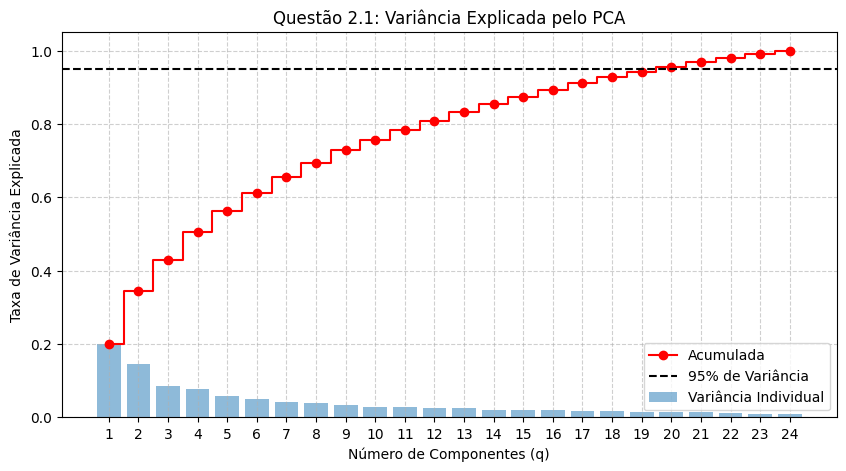

In [91]:
pca_full = PCA(n_components=None)
pca_full.fit(X)

var_ratio = pca_full.explained_variance_ratio_
var_acumulada = np.cumsum(var_ratio)

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(var_ratio) + 1), var_ratio, alpha=0.5, label='Variância Individual')
plt.step(range(1, len(var_acumulada) + 1), var_acumulada, where='mid', color='red', marker='o', label='Acumulada')
plt.ylabel('Taxa de Variância Explicada')
plt.xlabel('Número de Componentes (q)')
plt.title('Questão 2.1: Variância Explicada pelo PCA')
plt.xticks(range(1, len(var_ratio) + 1))
plt.axhline(y=0.95, color='k', linestyle='--', label='95% de Variância')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()